# Detection and replacement of OUTLIERS

## 2nd Approach - Using a moving mean 

This approach detects the outliers using the centered moving mean and moving standard deviation of one vertical profile. It detects as outliers the points that have a value bigger than its moving mean plus 2 times its moving standard deviation. This is a more general approach because it does not detect just single outliers as the previous approach. 

Nevertheless, we observed that this approach did not work well in the superficial zone. That is because a centered moving mean has not values in the first and last points (contour zones). To solve this, we implemented manually a not centered moving mean for the first values. 
To calculate the moving mean, we used an exponential weight function that “pandas” provides (pandas.DataFrame.ewm) with a window size of 7 values.


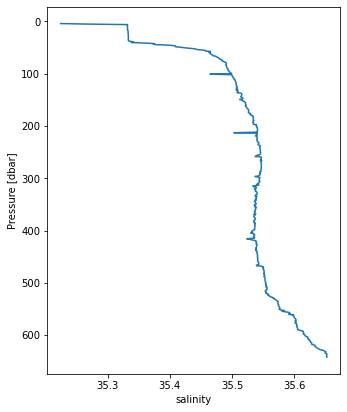

In [26]:
#Code of the 1st approach to detect and replace Outliers - zpau - 02/02/2022
#First, some imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import plotting_functions as plot

#Now we read the data
from read_CTD import read_CTD
data_dirs = ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

#We will work with the example of the salinity vertical profile number ncast='46'
#Let's see its form
ncast = '46'
variable = 'salinity'
data[ncast][variable].plot_cast()
plt.show()

In [37]:
#We observe that there are different points that seem to be outliers
#We establish a window size of 7 for calculate the moving means
window_size = 7
#We use an exponential weight calculation
mean = data[ncast][variable].ewm(window_size).mean()
std = data[ncast][variable].ewm(window_size).std()
std[0] = 0 #the first value turns into NaN because of no data

#We calculaete a moving mean non centered for the first values
#Mean of 1st value will be mean of the 7 first values
#Mean of the 2nd value will be the mean of the 2nd to the (2+7)th value
#...
for i in range(window_size):
    print('value numer ',i)
    print('old mean: ', mean.iloc[i], '     old std: ', std.iloc[i])
    mean.iloc[i]=data[ncast]['salinity'].iloc[i:i+window_size].mean()
    std.iloc[i]=data[ncast]['salinity'].iloc[i:i+window_size].std()
    print('new mean ', mean.iloc[i], '      new std: ', std.iloc[i])
    print()
std.iloc[0] = mean.iloc[0:0+window_size].std()

value numer  0
old mean:  35.2248      old std:  0.0
new mean  35.30731428571428       new std:  0.04386123681838015

value numer  1
old mean:  35.24693333333333      old std:  0.02934493141924116
new mean  35.32264285714286       new std:  0.024845580233571248

value numer  2
old mean:  35.27926153846154      old std:  0.05467289090582199
new mean  35.33202857142857       new std:  0.00018898223650309895

value numer  3
old mean:  35.295131563421826      old std:  0.05136948214777147
new mean  35.332       new std:  0.0001527525231640634

value numer  4
old mean:  35.30454162019923      old std:  0.046531860102076876
new mean  35.33204285714286       new std:  0.00012724180205497606

value numer  5
old mean:  35.310768522094186      old std:  0.04206969422165665
new mean  35.33208571428571       new std:  6.900655593358428e-05

value numer  6
old mean:  35.315179713711196      old std:  0.038172336498529746
new mean  35.3321       new std:  5.773502691882802e-05



perfil  46 :  12  outliers


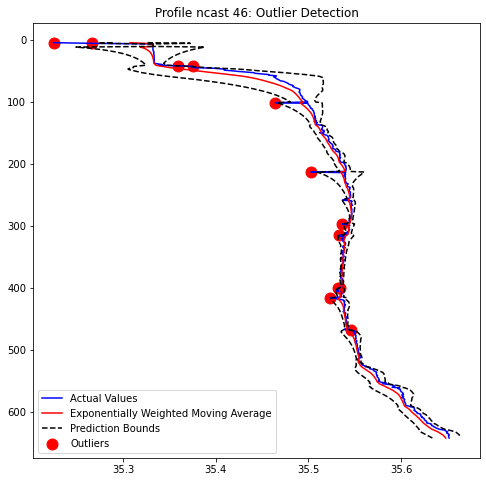

In [38]:
#We define the thresholds to detect the outliers
mean_plus_std = mean + 2*std
mean_minus_std = mean - 2*std

#Outlier detection
is_outlier = (data[ncast][variable] > mean_plus_std) | (data[ncast][variable] < mean_minus_std)
outliers = data[ncast][variable][is_outlier]
print('perfil ',ncast,': ',len(outliers),' outliers')

#We plot the vertical profile with the outliers marked
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data[ncast][variable],data[ncast].index, c = 'blue', label = 'Actual Values')
ax.plot(mean,data[ncast].index, c = 'r', label = 'Exponentially Weighted Moving Average')
ax.plot(mean_plus_std,data[ncast].index, 'k--', label = 'Prediction Bounds')
ax.plot(mean_minus_std,data[ncast].index, 'k--')
ax.scatter(outliers,outliers.index, c = 'r', marker = 'o', s = 120, label = 'Outliers')
ax.invert_yaxis()
plt.legend()
plt.title('Profile ncast '+ncast+': Outlier Detection')
#plt.savefig('OutlierDetection_'+ncast+'.png')
plt.show()

Once we detected the outliers, we removed them and replaced them for an interpolated value. 

This part of the code was a bit complicated because we had to differentiate the single outliers from the group of outliers. For the group of outliers, we calculated an interpolated value from the surrounding points of the whole group and assigned this value to the whole group. In case that the group of outliers was in the first or last positions, the replaced value was the first or last point that was not an outlier

In [39]:
#Detection of the index where are located the outliers
ind_outliers = []
for press_outlier in outliers.index:
    #print(press_outlier)
    index = 0
    for pressure in data[ncast].index:
        #print(pressure)
        if press_outlier == pressure:
            ind_outliers.append(index)
        index+=1
print('All the index of the outliers: ',ind_outliers)

#We separate the outliers that are grouped because their interpolation will be different
#This code gets the group of consectuive indexs and then remove the repited values
ind_outliers_cont=[]
count=0
for index in ind_outliers:
    if count==(len(ind_outliers)-1):
        break
    elif index == (ind_outliers[count+1] - 1):
        #print(index, ind_outliers[count+1])
        ind_outliers_cont.append(index)
        ind_outliers_cont.append(ind_outliers[count+1])
    count+=1    
result = []
for item in ind_outliers_cont:
    if item not in result:
        result.append(item)        
ind_outliers_cont = result

#Now we delete these outliers from the first list to have two list, one with the individual outliers and one with the group of outliers
for index in ind_outliers_cont:
    ind_outliers.remove(index)

#As there could be different groups of consecutive outliers, we make diffetent groups
change = []
diff = np.diff(ind_outliers_cont)
for i in range(len(diff)):
    if diff[i] != 1:
        change.append(i)
ind_cont = []
if len(change) == 0:
    ind_cont.append(ind_outliers_cont)
else:
    ind_cont.append(ind_outliers_cont[0:change[0]+1])
    for i in range(len(change)):
        if i == (len(change)-1):
            break
        else:
            ind_cont.append(ind_outliers_cont[change[i]+1:change[i+1]+1])
    ind_cont.append(ind_outliers_cont[change[-1]+1:])
    
print('Individual outliers: ', ind_outliers)
print('Group of outliers: ', ind_cont)

All the index of the outliers:  [0, 1, 37, 38, 96, 207, 290, 308, 392, 393, 408, 460]
Individual outliers:  [96, 207, 290, 308, 408, 460]
Group of outliers:  [[0, 1], [37, 38], [392, 393]]


In [40]:
#First, we interpolate the individual outliers
pres = data[ncast].index
var = data[ncast][variable].values
for index in ind_outliers:
    #If the outlier is in index=0, its replacement will be its moving mean (we could also replace it by the value in index=1)
    if index == 0:
        print('outlier in index ',index)
        print('value non interpolated: '+str(var[index]))
        var[0] == data[ncast][variable].iloc[0:0+window_size].mean()
        print('value interpolated: ' + str(data[ncast][variable].iloc[index]))
        print()
    #If the outlier is in the last index, its replaced value will be its previous value
    elif pres[index] == pres[-1]:
        print('outlier in index ',index)
        print('value non interpolated: '+str(var[index]))
        var[index]= var[index-1]
        print('value interpolated: ' + str(data[ncast]['salinity'].iloc[index]))
        print()
    #Else, interpolation between its surounding points
    else:
        print('outlier in index ',index)
        print('value non interpolated: '+str(var[index]))
        interp = scipy.interpolate.interp1d((pres[index-1],pres[index+1]),(var[index-1], var[index+1]))
        var[index]=interp(pres[index])
        print('value interpolated: ' + str(data[ncast]['salinity'].iloc[index]))
        print()

outlier in index  96
value non interpolated: 35.4644
value interpolated: 35.49910009915716

outlier in index  207
value non interpolated: 35.5027
value interpolated: 35.5403

outlier in index  290
value non interpolated: 35.5367
value interpolated: 35.54130019811788

outlier in index  308
value non interpolated: 35.5333
value interpolated: 35.53710183259039

outlier in index  408
value non interpolated: 35.5235
value interpolated: 35.53115

outlier in index  460
value non interpolated: 35.5465
value interpolated: 35.544402622464126



In [41]:
#Now, we replace the consecutive outliers
for i in ind_cont:  #Loop for each group
    #If there is an outlier in the index=0 the replacement value for the whole group will be the value after the group
    if 0 in i:     
        for index in i:
            print(index)
            print('outlier in index ',index)
            print('value non interpolated: '+str(var[index]))
            var[index] = var[i[-1]+1]
            print('value interpolated: ' + str(data[ncast][variable].iloc[index]))
            print()
    #Else, intepolation between the previous and the next value
    else:
        for index in i:
            print('outlier in index ',index)
            print('value non interpolated: '+str(var[index]))
            interp = scipy.interpolate.interp1d((pres[i[0]-1],pres[i[-1]+1]),(var[i[0]-1], var[i[-1]+1]))
            var[index]=interp(pres[index])
            print('value interpolated: ' + str(data[ncast][variable].iloc[index]))
            print()

0
outlier in index  0
value non interpolated: 35.2248
value interpolated: 35.3323

1
outlier in index  1
value non interpolated: 35.2663
value interpolated: 35.3323

outlier in index  37
value non interpolated: 35.3594
value interpolated: 35.34989609917355

outlier in index  38
value non interpolated: 35.3749
value interpolated: 35.36170390082645

outlier in index  392
value non interpolated: 35.5339
value interpolated: 35.534

outlier in index  393
value non interpolated: 35.5323
value interpolated: 35.5326



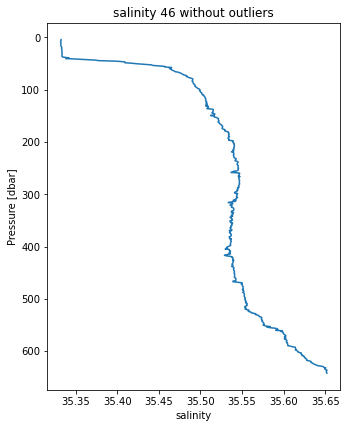

In [43]:
#We have already completed the method of detection and replacement of outliers
#Let's see the new profile without the outliers
plot.vert_profile(data,ncast,'salinity', savefig=False)
plt.title('salinity 46 without outliers')
plt.savefig('salinity_46_after')
plt.show()

In [11]:
#It seems that the approach worked correctly as the profile does not seem to have outliers
#Thus, let's create a function that generalize the approach so we can apply it to all the vertical profiles and variables

def out_outliers(data, ncast, variable, window_size=7):
    """Function that deletes and replace the outliers 
    of a vertical profile using a moving mean calculated
    by exponential weigth (ewm) """
    #Imports
    import scipy.interpolate
    import pandas as pd
    import numpy as np
    #Approach
    mean = data[ncast][variable].ewm(window_size).mean()
    std = data[ncast][variable].ewm(window_size).std()
    std[0]=0 #the first value turns into NaN because of no data
    #Manual calculation of the moving mean non centered for the first values
    for i in range(window_size):
        mean.iloc[i]=data[ncast]['salinity'].iloc[i:i+window_size].mean()
        std.iloc[i]=data[ncast]['salinity'].iloc[i:i+window_size].std()
    std.iloc[0] = mean.iloc[0:0+window_size].std()
    
    #Threshold to detect outliers
    limite_sup = mean + 2*std
    limite_inf = mean - 2*std
    is_outlier = (data[ncast][variable] > limite_sup) | (data[ncast][variable] < limite_inf)
    outliers = data[ncast][variable][is_outlier]
    
    #Index where are located the outliers
    ind_outliers = []
    for press_outlier in outliers.index:
        index = 0
        for pressure in data[ncast].index:
            if press_outlier == pressure:
                ind_outliers.append(index)
            index+=1
            
    #Grouping the consecutive outliers
    ind_outliers_cont=[]
    count=0
    for index in ind_outliers:
        if count==(len(ind_outliers)-1):
            break
        elif index == (ind_outliers[count+1] - 1):
            #print(index, ind_outliers[count+1])
            ind_outliers_cont.append(index)
            ind_outliers_cont.append(ind_outliers[count+1])
        count+=1
        
    #Delete of the duplicate index resulting from the previous step
    result = []
    for item in ind_outliers_cont:
        if item not in result:
            result.append(item)   
    ind_outliers_cont = result
    
    #Delete the consecutive index from the original list
    for index in ind_outliers_cont:
        ind_outliers.remove(index)
        
    #Grouping the consecutive index
    change = []
    diff = np.diff(ind_outliers_cont)
    for i in range(len(diff)):
        #print(i)
        if diff[i] != 1:
            change.append(i)
    ind_cont = []
    if len(change) == 0:
        ind_cont.append(ind_outliers_cont)
    else:
        ind_cont.append(ind_outliers_cont[0:change[0]+1])
        for i in range(len(change)):
            if i == (len(change)-1):
                break
            else:
                ind_cont.append(ind_outliers_cont[change[i]+1:change[i+1]+1])
        ind_cont.append(ind_outliers_cont[change[-1]+1:])
    
    #Interpolation of the individual outliers
    pressure = data[ncast].index
    var = data[ncast][variable].values
    for index in ind_outliers:
        if index == 0:
            var[0] == data[ncast][variable].iloc[0:0+window_size].mean()
        elif pressure[index] == pressure[-1]:
            var[index]= var[index-1]    
        else:
            interp = scipy.interpolate.interp1d((pressure[index-1],pressure[index+1]),(var[index-1], var[index+1]))
            var[index]=interp(pressure[index])
    
    #Interpolation of the consecutive outliers
    for i in ind_cont:
        if 0 in i:
            for index in i:
                var[index] = var[i[-1]+1]
        else:
            for index in i:
                interp = scipy.interpolate.interp1d((pressure[i[0]-1],pressure[i[-1]+1]),(var[i[0]-1], var[i[-1]+1]))
                var[index]=interp(pressure[index])